<a href="https://colab.research.google.com/github/SharonCamacho/Charla_Sesgos_Eafit/blob/main/An%C3%A1lisis_de_sesgo_Eafit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

# Sesgos históricos , variables proxy y conjuntos de datos desequilibrados

¿qué aspectos de sus datos pueden conducir a un modelo injusto?

# Importación de Librerías:


- numpy y pandas para la manipulación y análisis de datos.
- matplotlib.pyplot para la visualización de datos.
- xgboost para el modelado predictivo utilizando Gradient Boosting.
- sklearn.metrics para evaluar el rendimiento de los modelos.
- sklearn.feature_selection para técnicas de selección de características

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

# Carga y Exploración Inicial del Conjunto de Datos

In [106]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [107]:
df = X.copy()
df['income'] = y

In [108]:
df = df.dropna()

print(df.shape)
df.head()

(47621, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [109]:
#Para el ejercicio tomaremos solo algunas varibles
df[['age','education-num','marital-status','occupation',
    'hours-per-week','native-country',
    'race','sex','income']].head(10)

,age,education-num,marital-status,occupation,hours-per-week,native-country,race,sex,income
0,39,13,Never-married,Adm-clerical,40,United-States,White,Male,<=50K
1,50,13,Married-civ-spouse,Exec-managerial,13,United-States,White,Male,<=50K
2,38,9,Divorced,Handlers-cleaners,40,United-States,White,Male,<=50K
3,53,7,Married-civ-spouse,Handlers-cleaners,40,United-States,Black,Male,<=50K
4,28,13,Married-civ-spouse,Prof-specialty,40,Cuba,Black,Female,<=50K
5,37,14,Married-civ-spouse,Exec-managerial,40,United-States,White,Female,<=50K
6,49,5,Married-spouse-absent,Other-service,16,Jamaica,Black,Female,<=50K
7,52,9,Married-civ-spouse,Exec-managerial,45,United-States,White,Male,>50K
8,31,14,Never-married,Prof-specialty,50,United-States,White,Female,>50K
9,42,13,Married-civ-spouse,Exec-managerial,40,United-States,White,Male,>50K


## Análisis Exploratorio

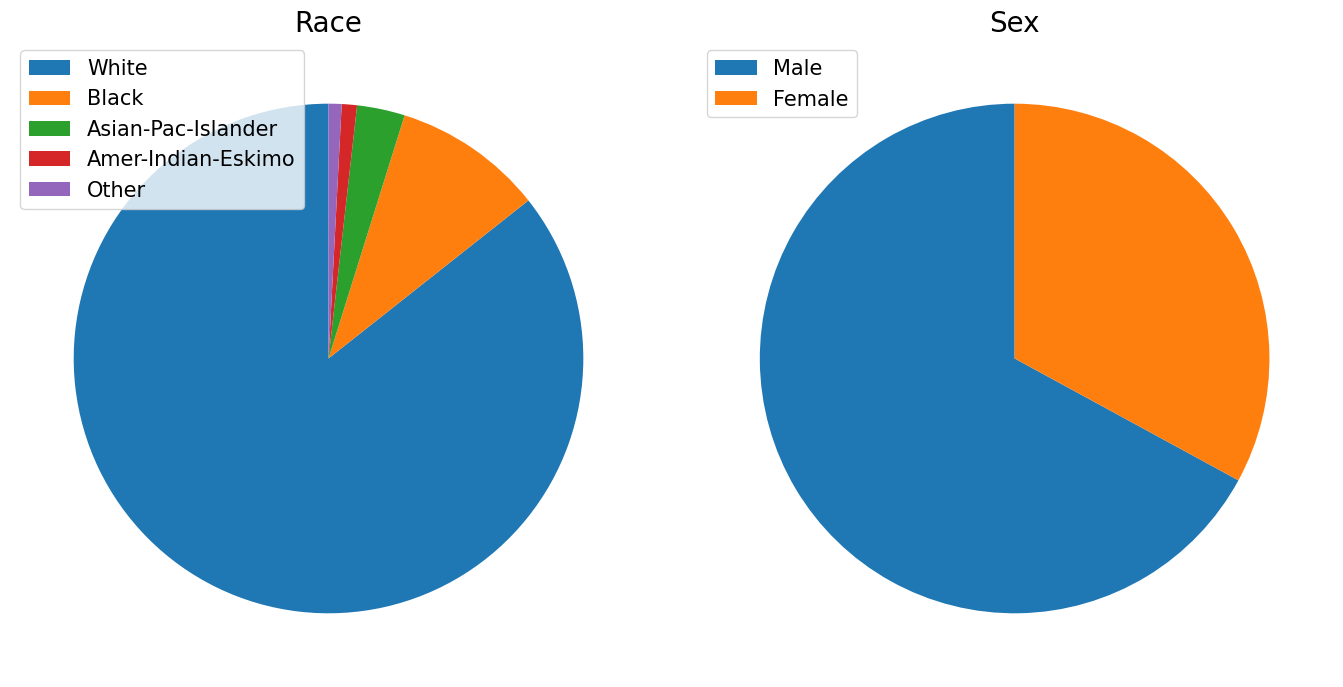

In [110]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Gráfica por raza
counts = df['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

plt.subplot(122)

#Gráfica por sexo
counts = df['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Sex",size=20)


plt.tight_layout(pad=2)
#plt.savefig(path.format('unbalnced_datsets.png'),format='png',dpi=150)

## Variables Protegidas

In [111]:
df_fair = df[['race','sex']].copy()

#Definimos las variables protegidas

df_fair.loc[:, 'priv_race'] = df_fair['race'].apply(lambda x: 1 if x == 'White' else 0)
df_fair.loc[:, 'priv_sex'] = df_fair['sex'].apply(lambda x: 1 if x == 'Male' else 0)

#Definimos la variable objetivo
df_fair['y'] = df['income'].apply(lambda y: 1 if y == '>50K' else 0)

df_fair.head()

,race,sex,priv_race,priv_sex,y
0,White,Male,1,1,0
1,White,Male,1,1,0
2,White,Male,1,1,0
3,Black,Male,0,1,0
4,Black,Female,0,0,0


## Prevalencia

La prevalencia es la proporción de casos positivos con respecto al total de casos

In [112]:
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

print(prev)
print("\n")
print(prev_race)
print("\n")
print(prev_sex)
print("\n")
print(prev_comb)

0.1646542491757838


priv_race
0    0.105925
1    0.174496
Name: y, dtype: float64


priv_sex
0    0.075172
1    0.208598
Name: y, dtype: float64


priv_race  priv_sex
0          0           0.049443
           1           0.151547
1          0           0.081394
           1           0.216259
Name: y, dtype: float64


In [113]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

## Variables Proxy

Son características del modelo que están altamente correlacionadas o asociadas con nuestras características protegidas. Un modelo que utiliza una variable proxy puede utilizar efectivamente una característica protegida para tomar decisiones.
Utilizamos alguna medida de asociación entre las características y la variable objetivo. Examinaremos dos medidas de asociación:
- Información mutua
- Importancia de features

In [114]:
#Variable objetivo
y = [1 if value == '>50K' else 0 for value in df['income']]

# Creando las características del modelo
X = df[['age', 'education-num', 'hours-per-week']].copy()
X['marital-status'] = df['marital-status'].apply(lambda x: 1 if x == 'Married-civ-spouse' else 0)
X['native-country'] = df['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)

# Diccionario para categorizar 'occupation'
occ_groups = {
    'Priv-house-serv': 0, 'Other-service': 0, 'Handlers-cleaners': 0,
    'Farming-fishing': 1, 'Machine-op-inspct': 1, 'Adm-clerical': 1,
    'Transport-moving': 2, 'Craft-repair': 2, 'Sales': 2,
    'Armed-Forces': 3, 'Tech-support': 3, 'Protective-serv': 3,
    'Prof-specialty': 4, 'Exec-managerial': 4
}

X['occupation'] = [occ_groups.get(occupation, -1) for occupation in df['occupation']]

X.head()


,age,education-num,hours-per-week,marital-status,native-country,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


### Información Mutua

In [115]:
#Se calcula la información mutua
mut_race = mutual_info_classif(X, df_fair['priv_race'], discrete_features=[1, 3, 4, 5])
mut_sex = mutual_info_classif(X, df_fair['priv_sex'], discrete_features=[1, 3, 4, 5])


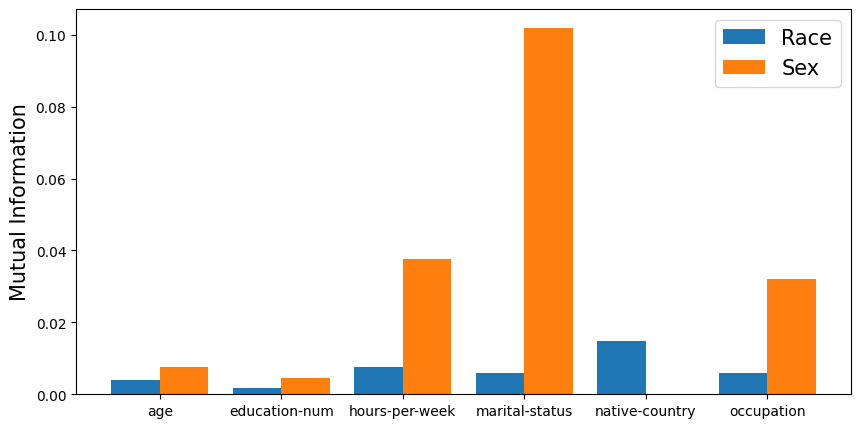

<Figure size 640x480 with 0 Axes>

In [116]:
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']
x = np.arange(len(labels))
width = 0.4
plt.bar(x-width/2,height= mut_race,width=width,label='Race')
plt.bar(x+width/2,height= mut_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information',size=15)
plt.xticks(ticks=x,labels=labels)

plt.show()

# Guardar el gráfico
plt.savefig("Mutual_information.png", dpi=100)

## Importancia de features


**Importancia de features para raza**

In [120]:

# Muestra equilibrada
y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = pd.concat([y_race_0,y_race_1])

X_race = X.loc[y_race.index]

# Entrenamiento del modelo y predicción
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

# Metricas
acc_race = accuracy_score(y_race, y_pred)

# Importancia de features
fi_race = model.get_booster().get_score(importance_type='weight')


#Resultados
print('Accuracy')
print(acc_race)
print("\n")
print('Matriz de Confusion')
print(confusion_matrix(y_race, y_pred))
print("\n")
print('Reporte')
print(classification_report(y_race, y_pred))

Accuracy
0.7350402340892466


Matriz de Confusion
[[5032 1803]
 [1819 5016]]


Reporte
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      6835
           1       0.74      0.73      0.73      6835

    accuracy                           0.74     13670
   macro avg       0.74      0.74      0.74     13670
weighted avg       0.74      0.74      0.74     13670



**Importancia de Features para Sexo**

In [121]:
# Muestra equilibrada
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = pd.concat([y_sex_0,y_sex_1])

X_sex = X.loc[y_sex.index]

# Entrenamiento del modelo y predicción
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

# Metricas
acc_sex = accuracy_score(y_sex, y_pred)

# Importancia de features
fi_sex = model.get_booster().get_score(importance_type='weight')

#Resultados
print('Accuracy')
print(acc_sex)
print("\n")
print('Matriz de Confusion')
print(confusion_matrix(y_sex, y_pred))
print("\n")
print('Reporte')
print(classification_report(y_sex, y_pred))

Accuracy
0.791347870441214


Matriz de Confusion
[[13313  2371]
 [ 4174 11510]]


Reporte
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     15684
           1       0.83      0.73      0.78     15684

    accuracy                           0.79     31368
   macro avg       0.80      0.79      0.79     31368
weighted avg       0.80      0.79      0.79     31368



In [138]:
#Antes del Balanceo
#df_fair['y'].hist()

In [137]:
#Luego del Balanceo
#y_sex.hist()

# Qué tan justo es el modelo?

## Modelo


In [ ]:
#Train model
model = xgb.XGBClassifier(objective="binary:logistic", use_label_encoder=False)
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print("Matriz de Confusión")
print(confusion_matrix(y, y_pred))
print("\n")
print("accuracy_score")
print(accuracy_score(y, y_pred))
print("\n")
print("classification_repor")
print(classification_report(y, y_pred))

Matriz de Confusión
[[38238  1542]
 [ 5329  2512]]


accuracy_score
0.8557149156884568


classification_repor
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     39780
           1       0.62      0.32      0.42      7841

    accuracy                           0.86     47621
   macro avg       0.75      0.64      0.67     47621
weighted avg       0.84      0.86      0.84     47621



## Métricas de justicia

In [ ]:
def fairness_metrics(df):
    """Calcula la justicia por subgrupos de población"""

    #Matriz de confusión
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    N = TP+FP+FN+TN

    #Accuracy General
    ACC = (TP+TN)/N

    # Tasa de TP
    TPR = TP/(TP+FN)

    # Tasa de FP
    FPR = FP/(FP+TN)

    # Tasa de FN
    FNR = FN/(TP+FN)

    # Porcentaje de predichos como positivos
    PPP = (TP + FP)/N

    return np.array([ACC, TPR, FPR, FNR, PPP])


In [ ]:
#Metricas de justicia para raza
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Metricas de ratio de justicia
fm_race = fm_race_0/fm_race_1

print("Metricas de justicia para raza")
print("Acc, TP, FP, FN, PPP")
print("\n")
print("Privilegiados")
print(fm_race_1)
print("No Privilegiados")
print(fm_race_0)
print("\n")
print("ratio")
print(fm_race)

Metricas de justicia para raza
Acc, TP, FP, FN, PPP


Privilegiados
[0.84781543 0.32204581 0.04104666 0.67795419 0.09007993]
No Privilegiados
[0.90285296 0.3038674  0.02618229 0.6961326  0.0555962 ]


ratio
[1.06491688 0.94355336 0.63786662 1.02681361 0.61718738]


In [ ]:
#Metricas de justicia para sexo
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Metricas de ratio de justicia
fm_sex = fm_sex_0/fm_sex_1

print("Metricas de justicia para sexo")
print("Acc, TP, FP, FN, PPP")
print("\n")
print("Privilegiados")
print(fm_sex_1)
print("No Privilegiados")
print(fm_sex_0)
print("ratio")
print(fm_sex)

Metricas de justicia para sexo
Acc, TP, FP, FN, PPP


Privilegiados
[0.81789147 0.33968778 0.0560633  0.66031222 0.11522685]
No Privilegiados
[0.932734   0.21119593 0.00861772 0.78880407 0.02384596]
ratio
[1.14041291 0.62173543 0.15371406 1.19459257 0.20694792]


Tomado de https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705